In [13]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns


In [14]:
df = pd.read_csv(r'C:\Users\joshu\OneDrive\Desktop\CS74\Final_Project\music_econ_topics_merged.csv')

feature_cols = ['danceability', 'energy', 'valence', 'tempo', 
                'acousticness', 'instrumentalness', 'speechiness', 'loudness','pos', 'neg']

df_clean = df[feature_cols + ['week_date', 'USREC']].dropna()

print(f"\nData: {len(df_clean)} months")
print(f"Features: {feature_cols}")


Data: 569 months
Features: ['danceability', 'energy', 'valence', 'tempo', 'acousticness', 'instrumentalness', 'speechiness', 'loudness', 'pos', 'neg']


In [15]:
#In order to account for scale differences in variables, I will be using scaler = StandardScaler()
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_clean[feature_cols])


In [16]:
#K-means from scrath.

def k_means_music(df, feature_cols, K, method='mean', max_iter=100, init_method='random_seed'):

    df_copy = df.copy()

    if init_method == 'random_seed':
        centroids = df.sample(n=K, random_state=42)
        df_copy['cluster'] = np.zeros(len(df_copy), dtype=int)

    elif init_method == 'random_split':
        np.random.seed(42)
        df_copy['cluster'] = np.random.randint(0, K, size=len(df_copy))
        
    #centroids list [5, len(feature_cols)]
    centroids = np.zeros((K, len(feature_cols)))
    for k in range(K):
        cluster_points = df_copy[df_copy['cluster'] == k][feature_cols]
        if len(cluster_points) > 0:
            if method == 'mean':
                centroids[k] = cluster_points.mean(axis=0).values
            elif method == 'median':
                centroids[k] = cluster_points.median().values

    prev_clusters = np.zeros(len(df_copy))
    for i in range(max_iter):
        distances = np.zeros((len(df_copy), K))
        for k in range(K):

            diff = df_copy[feature_cols].values - centroids[k]
            distances[:, k] = np.sqrt((diff ** 2).sum(axis=1))
        
        df_copy['cluster'] = np.argmin(distances, axis=1)

        if np.array_equal(df_copy['cluster'].values, prev_clusters):
            print(f"k :Converged after {i} iterations")
            break
                    
        prev_clusters = df_copy['cluster'].values.copy()
                
                # Recalculate centroids
        for k in range(K):
            cluster_points = df_copy[df_copy['cluster'] == k][feature_cols]
            if len(cluster_points) > 0:
                if method == 'mean':
                    centroids[k] = cluster_points.mean(axis=0)
                else:
                    centroids[k] = np.median(cluster_points, axis=0)
            
    return df_copy, centroids, i


Silhoutte Scores


In [17]:
def func(b, a):
    return (b - a) / max(a, b)

    
    #for each data point
    #a: distance to other datapoier
    #b: average distance to all other clusters 
def silhouette_score(df,cluster_list):
    n = len(df)
    silhouette_scores = []


    for i in range(n): #outer loop, looping over all clusters
        same_cluster_points = [] #points of the same cluster
        other_clusters_points = {} #key: cluster , val: point

        cluster_i = cluster_list[i] 
        for j in range(n):
            cluster_j = cluster_list[j]

            if cluster_list[j] == cluster_i and j != i:
                same_cluster_points.append(df.iloc[j]) #df.iloc[j] holds both x and y values


            elif cluster_j != cluster_i:
                if cluster_j not in other_clusters_points:
                    other_clusters_points[cluster_j] = []
                other_clusters_points[cluster_j].append(df.iloc[j])



        # compute a(i)
        if same_cluster_points:
            total_dist = 0
            for point in same_cluster_points:
                a_i = ((df.iloc[i] - point)**2)
                a_i = a_i.sum() ** 0.5
                total_dist += a_i

            a_i = total_dist/len(same_cluster_points)
                
                
        else:
            a_i = 0

        # compute b(i)
        b_i_list = [] # populated by the average distances betewen poin t i and the other clusters
        for points in other_clusters_points.values():
            total_b_dist = 0
            for p in points:
                diff = df.iloc[i] - p
                dist = np.sqrt((diff ** 2).sum())  
                total_b_dist += dist
            mean_b = total_b_dist / len(points)
            b_i_list.append(mean_b)  #


        b_i = min(b_i_list) if b_i_list else 0

        silhouette_scores.append(func(b_i, a_i))

    return np.mean(silhouette_scores)

In [18]:
print("Using BOTH elbow method AND my silhouette score\n")

K_range = range(2, 4)
inertias = []
silhouette_scores = []

for L in K_range:
    print(f"test")

df_clustered, centroids, i = k_means_music(pd.DataFrame(df_scaled, columns=feature_cols),
                                           feature_cols=feature_cols,
                                           K=3, method='mean')
score = silhouette_score(pd.DataFrame(df_scaled, columns=feature_cols), df_clustered['cluster'])
silhouette_scores.append(score)

for k, s in zip(K_range, silhouette_scores):
    print(f"K={k}: {s:.4f}")


Using BOTH elbow method AND my silhouette score

test
test
k :Converged after 12 iterations
K=2: 0.2805


In [19]:
#elbow method to find the best number of clusters
#1. Intertia is the sum of squared distances from each point to its assigned cluster center. It tells us how well the points are grouped in their clusters. The samller the inertia, the better the clustering.
#2 we plot the niertia for diff values of K. As K increases the intertia decrease because more lcusters allow data points to be closer to their cluster centers
#3. The goal is to find the value of K where the decrease in inertia starts to slow down. This is called the "elbow point" because the plot looks like an arm bending at the elbow. oPTIMAL K.

In [20]:
print("Final Model with K=3")

df_clustered_final, final_centroids, final_iterations = k_means_music(
    pd.DataFrame(df_scaled, columns=feature_cols),
    feature_cols=feature_cols,
    K=3,
    method='mean'
)

print(f" Converged after {final_iterations} iterations")
final_silhouette = silhouette_score(
    pd.DataFrame(df_scaled, columns=feature_cols),
    df_clustered_final['cluster']
)
print(f"Final silhouette score: {final_silhouette:.4f}")

# Add clusters back to OG (unstandardized) data
df_clean['cluster'] = df_clustered_final['cluster'].values

# Show cluster sizes
print("Cluster Distribution:")
cluster_counts = df_clean['cluster'].value_counts().sort_index()
for cluster, count in cluster_counts.items():
    pct = (count / len(df_clean)) * 100
    print(f"  Cluster {cluster}: {count:3d} months ({pct:5.1f}%)")


Final Model with K=3
k :Converged after 12 iterations
 Converged after 12 iterations
Final silhouette score: 0.2805
Cluster Distribution:
  Cluster 0: 234 months ( 41.1%)
  Cluster 1: 137 months ( 24.1%)
  Cluster 2: 198 months ( 34.8%)



Data: 569 months
Features: ['danceability', 'energy', 'valence', 'tempo', 'acousticness', 'instrumentalness', 'speechiness', 'loudness']
✓ Clustered 569 months into 3 groups
✓ Chart saved as 'kmeans_recession_comparison.png'


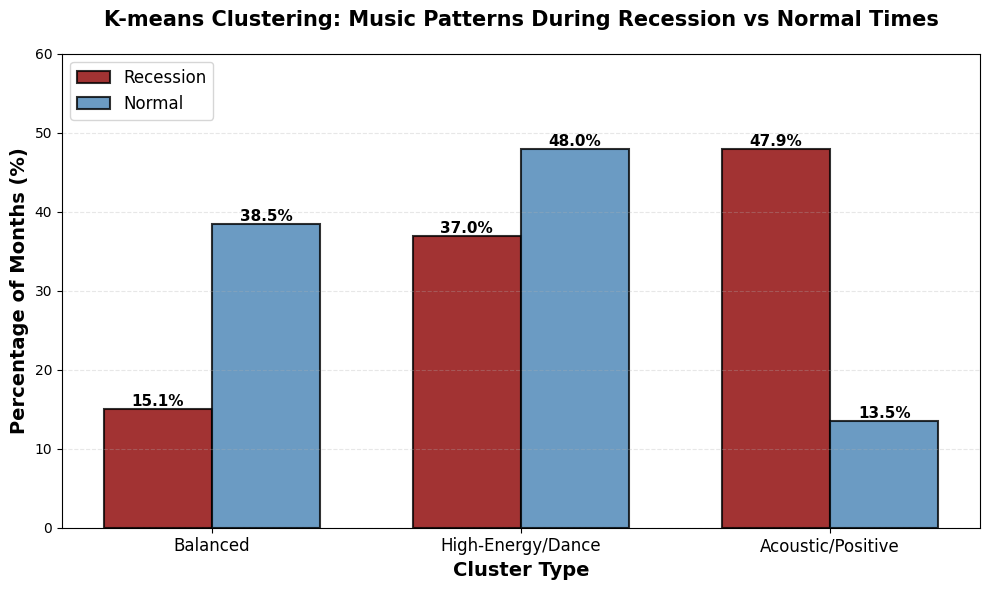

FINDINGS

Balanced            :
  Normal:     38.5%
  Recession:  15.1%
  Change:    -23.4 percentage points
High-Energy/Dance   :
  Normal:     48.0%
  Recession:  37.0%
  Change:    -11.0 percentage points
Acoustic/Positive   :
  Normal:     13.5%
  Recession:  47.9%
  Change:    +34.4 percentage points
Statistical Test: x² = 53.60, p = 0.0000


In [23]:
"""
K-Means Clustering: Recession vs Normal Comparison
Produces single publication-ready bar chart for poster
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


df = pd.read_csv('music_econ_topics_merged.csv')

feature_cols = ['danceability', 'energy', 'valence', 'tempo', 
                'acousticness', 'instrumentalness', 'speechiness', 'loudness']

df_clean = df[feature_cols + ['week_date', 'USREC']].dropna()
print(f"\nData: {len(df_clean)} months")
print(f"Features: {feature_cols}")

# Standardize features (required for K-means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean[feature_cols])

# Fit K-means with K=3
kmeans = KMeans(n_clusters=3, random_state=42, n_init=20)
df_clean['cluster'] = kmeans.fit_predict(X_scaled)

#   labels based on cluster analysis on k-means_analysis.ipynb
cluster_labels = {
    0: "Balanced",
    1: "High-Energy/Dance",
    2: "Acoustic/Positive"
}

print(f"✓ Clustered {len(df_clean)} months into 3 groups")


fig, ax = plt.subplots(figsize=(10, 6))

recession_pcts = []
normal_pcts = []
cluster_names = []

for cluster in range(3):
    recession_in_cluster = ((df_clean['cluster'] == cluster) & (df_clean['USREC'] == 1)).sum()
    normal_in_cluster = ((df_clean['cluster'] == cluster) & (df_clean['USREC'] == 0)).sum()
    total_recession = (df_clean['USREC'] == 1).sum()
    total_normal = (df_clean['USREC'] == 0).sum()
    
    recession_pct = (recession_in_cluster / total_recession) * 100
    normal_pct = (normal_in_cluster / total_normal) * 100
    
    recession_pcts.append(recession_pct)
    normal_pcts.append(normal_pct)
    cluster_names.append(cluster_labels[cluster])

# Create grouped bar chart
x = np.arange(len(cluster_names))
width = 0.35

bars1 = ax.bar(x - width/2, recession_pcts, width, label='Recession', 
               color='darkred', alpha=0.8, edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, normal_pcts, width, label='Normal', 
               color='steelblue', alpha=0.8, edgecolor='black', linewidth=1.5)

# Add percentage labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom', fontsize=11, fontweight='bold')

# Formatting
ax.set_xlabel('Cluster Type', fontsize=14, fontweight='bold')
ax.set_ylabel('Percentage of Months (%)', fontsize=14, fontweight='bold')
ax.set_title('K-means Clustering: Music Patterns During Recession vs Normal Times', 
             fontsize=15, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(cluster_names, fontsize=12)
ax.legend(fontsize=12, loc='upper left')
ax.grid(True, alpha=0.3, axis='y', linestyle='--')
ax.set_ylim(0, 60)

plt.tight_layout()
plt.savefig('kmeans_recession_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Chart saved as 'kmeans_recession_comparison.png'")
plt.show()



print("FINDINGS")

for i, cluster in enumerate(range(3)):
    diff = recession_pcts[i] - normal_pcts[i]
    print(f"\n{cluster_labels[cluster]:20s}:")
    print(f"  Normal:    {normal_pcts[i]:5.1f}%")
    print(f"  Recession: {recession_pcts[i]:5.1f}%")
    print(f"  Change:    {diff:+5.1f} percentage points", end="")
    

# Statistical test
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(df_clean['cluster'], df_clean['USREC'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"\nStatistical Test: x² = {chi2:.2f}, p = {p_value:.4f}")


NameError: name 'VISUALS_DIR' is not defined

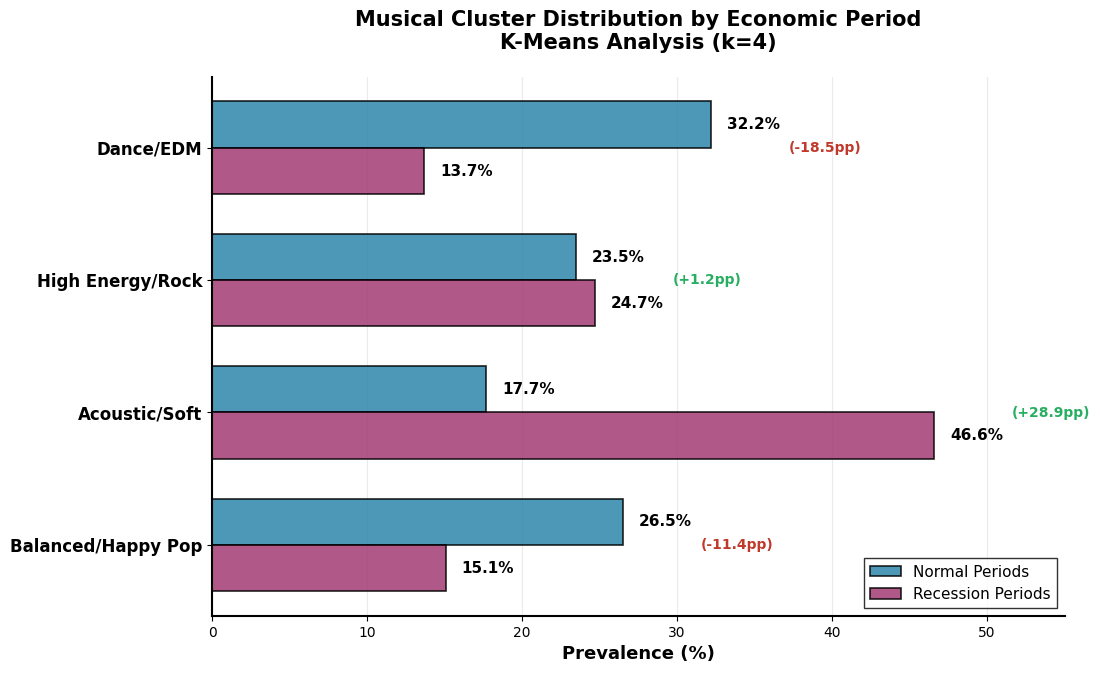

In [ ]:
### TEST with 4 Clusters, weaker significance and subjective naming 


import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(11, 7))

# Data
clusters = ['Balanced/Happy Pop', 'Acoustic/Soft', 'High Energy/Rock', 'Dance/EDM']
normal = [26.5, 17.7, 23.5, 32.2] #found by .ipynb
recession = [15.1, 46.6, 24.7, 13.7]

y = np.arange(len(clusters))
height = 0.35

# Professional colors
normal_color = '#2E86AB'    
recession_color = '#A23B72'  

# Horizontal bars
bars1 = ax.barh(y + height/2, normal, height, 
                label='Normal Periods', 
                color=normal_color, 
                edgecolor='black', 
                linewidth=1.2,
                alpha=0.85)

bars2 = ax.barh(y - height/2, recession, height, 
                label='Recession Periods', 
                color=recession_color,
                edgecolor='black', 
                linewidth=1.2,
                alpha=0.85)
for bars, values in [(bars1, normal), (bars2, recession)]:
    for bar, val in zip(bars, values):
        width = bar.get_width()
        ax.text(width + 1, bar.get_y() + bar.get_height()/2,
               f'{val:.1f}%',
               ha='left', va='center', 
               fontsize=11, fontweight='bold')
changes = [recession[i] - normal[i] for i in range(len(clusters))]
for i, change in enumerate(changes):
    x_pos = max(normal[i], recession[i]) + 5
    if change > 0:
        color = "#61a17c"
        text = f'(+{change:.1f}pp)'


    else:
        color = '#c0392b'
        text = f'({change:.1f}pp)'
    


    ax.text(x_pos, i, text, 
           ha='left', va='center',
           fontsize=10, fontweight='bold',
           color=color)

# Styling
ax.set_yticks(y)
ax.set_yticklabels(clusters, fontsize=12, fontweight='bold')
ax.set_xlabel('Prevalence (%)', fontsize=13, fontweight='bold')
ax.set_title('Musical Cluster Distribution by Economic Period\nK-Means Analysis (k=4)', 
             fontsize=15, fontweight='bold', pad=20)
ax.set_xlim([0, 55])

# Legend
ax.legend(fontsize=11, loc='lower right', frameon=True, 
         edgecolor='black', fancybox=False)

# Grid
ax.grid(True, alpha=0.25, axis='x', linestyle='-', linewidth=0.8)
ax.set_axisbelow(True)

# Clean spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)


plt.savefig(f'{VISUALS_DIR}/poster_cluster_clean.png', 
           dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("\n✓ Saved clean horizontal version: poster_cluster_clean.png")